<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/fuzzyLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy -q

0.8055555555555557


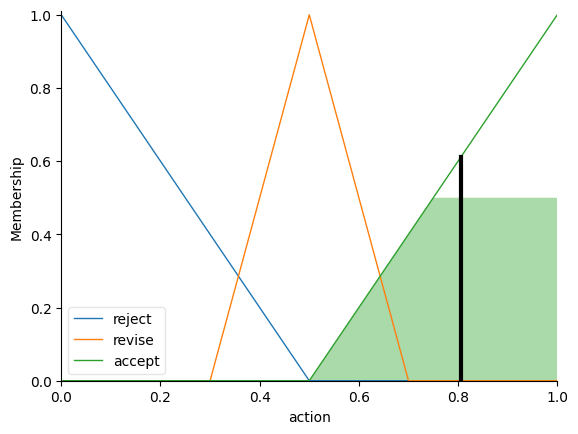

In [3]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define linguistic variables for LLM confidence and sentiment score
confidence = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'confidence')
sentiment = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'sentiment')
action = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'action')

# Define membership functions for each variable
confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['medium'] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence['high'] = fuzz.trimf(confidence.universe, [0.5, 1, 1])

sentiment['negative'] = fuzz.trimf(sentiment.universe, [-1, -1, 0])
sentiment['neutral'] = fuzz.trimf(sentiment.universe, [-0.5, 0, 0.5])
sentiment['positive'] = fuzz.trimf(sentiment.universe, [0, 1, 1])

action['reject'] = fuzz.trimf(action.universe, [0, 0, 0.5])
action['revise'] = fuzz.trimf(action.universe, [0.3, 0.5, 0.7])
action['accept'] = fuzz.trimf(action.universe, [0.5, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(confidence['low'] & sentiment['negative'], action['reject'])
rule2 = ctrl.Rule(confidence['medium'] & sentiment['negative'], action['revise'])
rule3 = ctrl.Rule(confidence['high'] & sentiment['negative'], action['revise'])
rule4 = ctrl.Rule(confidence['low'] & sentiment['neutral'], action['revise'])
rule5 = ctrl.Rule(confidence['medium'] & sentiment['neutral'], action['revise'])
rule6 = ctrl.Rule(confidence['high'] & sentiment['neutral'], action['accept'])
rule7 = ctrl.Rule(confidence['low'] & sentiment['positive'], action['revise'])
rule8 = ctrl.Rule(confidence['medium'] & sentiment['positive'], action['accept'])
rule9 = ctrl.Rule(confidence['high'] & sentiment['positive'], action['accept'])

# Create and simulate the control system
action_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
action_sim = ctrl.ControlSystemSimulation(action_ctrl)

# Example usage:
# Assume LLM generates text with confidence 0.6 and sentiment score 0.8
action_sim.input['confidence'] = 0.6
action_sim.input['sentiment'] = 0.8
action_sim.compute()

# Print the output (action to take)
print(action_sim.output['action'])
action.view(sim=action_sim)